[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [3]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [12]:
cur = conn.cursor()
res = cur.execute("SELECT * FROM sqlite_master WHERE type='table';")
res.fetchall()

[('table',
  'checkpoints',
  'checkpoints',
  2,
  "CREATE TABLE checkpoints (\n                thread_id TEXT NOT NULL,\n                checkpoint_ns TEXT NOT NULL DEFAULT '',\n                checkpoint_id TEXT NOT NULL,\n                parent_checkpoint_id TEXT,\n                type TEXT,\n                checkpoint BLOB,\n                metadata BLOB,\n                PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id)\n            )"),
 ('table',
  'writes',
  'writes',
  4,
  "CREATE TABLE writes (\n                thread_id TEXT NOT NULL,\n                checkpoint_ns TEXT NOT NULL DEFAULT '',\n                checkpoint_id TEXT NOT NULL,\n                task_id TEXT NOT NULL,\n                idx INTEGER NOT NULL,\n                channel TEXT NOT NULL,\n                type TEXT,\n                value BLOB,\n                PRIMARY KEY (thread_id, checkpoint_ns, checkpoint_id, task_id, idx)\n            )")]

In [13]:
res = cur.execute("SELECT * FROM checkpoints;")
res.fetchall()

[('1',
  '',
  '1ef64b22-3155-65d8-bfff-cb35a53ab872',
  None,
  'json',
  b'{"v": 1, "ts": "2024-08-27T20:22:52.733166+00:00", "id": "1ef64b22-3155-65d8-bfff-cb35a53ab872", "channel_values": {"messages": [], "__start__": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m Lance", "type": "human"}}]}}, "channel_versions": {"__start__": "00000000000000000000000000000001.761a8c54329ca020d4813f3f8164401b"}, "versions_seen": {"__input__": {}}, "pending_sends": [], "current_tasks": {}}',
  b'{"source": "input", "writes": {"messages": [{"lc": 1, "type": "constructor", "id": ["langchain", "schema", "messages", "HumanMessage"], "kwargs": {"content": "hi! I\'m Lance", "type": "human"}}]}, "step": -1}'),
 ('1',
  '',
  '1ef64b22-315d-6eae-8000-a235a23be95b',
  '1ef64b22-3155-65d8-bfff-cb35a53ab872',
  'json',
  b'{"v": 1, "ts": "2024-08-27T20:22:52.736675+00:00", "id": "1ef64b22-315d-6eae-8000-a235a23be95b", "c

In [14]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [15]:

from langchain_google_vertexai import ChatVertexAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

from langchain_google_vertexai import ChatVertexAI
model = ChatVertexAI(model="gemini-pro",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 4:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

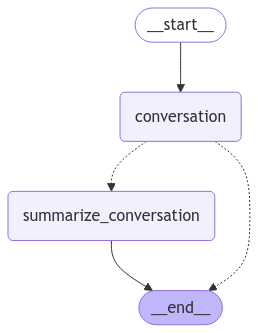

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [17]:
# Create a thread
config = {"configurable": {"thread_id": "10"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm vikas")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

print(f"messages len: {len(output['messages'])}")

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

print(f"messages len: {len(output['messages'])}")

input_message = HumanMessage(content="i like bollywood!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

print(f"messages len: {len(output['messages'])}")


================================== Ai Message ==================================

Hi Vikas, it's nice to meet you! What would you like to talk about today?
messages len: 2
================================== Ai Message ==================================

You just told me your name is Vikas. Is there anything else you'd like to tell me about yourself?
messages len: 4
================================== Ai Message ==================================

That's great! Bollywood is a vibrant and exciting industry with a rich history. What are some of your favorite Bollywood movies or actors? 

I can also share some interesting facts about Bollywood with you, if you'd like.
messages len: 2


Let's confirm that our state is saved locally.

In [19]:
config = {"configurable": {"thread_id": "10"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content='i like bollywood!', additional_kwargs={}, response_metadata={}, id='9a27d615-a4e9-455d-866a-2a63c5ab798d'), AIMessage(content="That's great! Bollywood is a vibrant and exciting industry with a rich history. What are some of your favorite Bollywood movies or actors? \n\nI can also share some interesting facts about Bollywood with you, if you'd like. \n", additional_kwargs={}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.04541015625, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.0341796875}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'probability_score': 0.03515625, 'blocked': False, 'severity': 'HARM_SEVERITY_NEGLIGIBLE', 'severity_score': 0.044677734375}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'probability_scor

In [ ]:
graph_state[

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", id='d5bb4b3f-b1e9-4f61-8c75-7a7210b30253'), AIMessage(content="Hello again, Lance! It's great to hear from you. Since you like the 49ers, is there a particular player or moment in their history that stands out to you? Or perhaps you'd like to discuss their current season? Let me know!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 337, 'total_tokens': 387}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5', 'finish_reason': 'stop', 'logprobs': None}, id='run-dde04d51-d305-4a9e-8ad5-6bdf5583196e-0', usage_metadata={'input_tokens': 337, 'output_tokens': 50, 'total_tokens': 387}), HumanMessage(content="what's my name?", id='d7530770-f130-4a05-a602-a96fd87859c6'), AIMessage(content='Your name is Lance! How can I assist you today? Would you like to talk more about the San Francisco 49ers or something else?', additional_kwargs={'

## LangGraph Studio

--

**⚠️ DISCLAIMER**

*Running Studio currently requires a Mac. If you are not using a Mac, then skip this step.*

--

Now that we better understand external memory, recall that the LangGraph API packages your code and provides you with with built-in persistence.
 
And the API is the back-end for Studio! 

Load the `chatbot` in the UI, which uses `module2-/studio/chatbot.py` set in `module2-/studio/langgraph.json`.